In [6]:
import os
import gradio as gr
import requests
%env OPENAI_API_KEY
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

def generate(prompt):
    n = 1
    size = "512x512"
    data = {"n": n, "prompt": prompt, "size": size}
    headers = {"Content-Type": "application/json",
               "Authorization": f"""Bearer {OPENAI_API_KEY}"""}
    result = requests.post(
        "https://api.openai.com/v1/images/generations", json=data, headers=headers)
    return result.json()["data"][0]["url"]

iface = gr.Interface(
    fn=generate,
    inputs=[gr.Textbox(placeholder="Prompt", label="Prompt")],
    outputs="image"
)
iface.launch()


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


Loaded as API: https://passant-labs-aigc.hf.space/ ✔
img_path:
/var/folders/v9/0m7ffhxx1mn6dxrl_nxks6y00000gn/T/gradio/73407bfa8265b5dcb2aac0e2240b1661df8153bc/tmpa1k_32ru.png


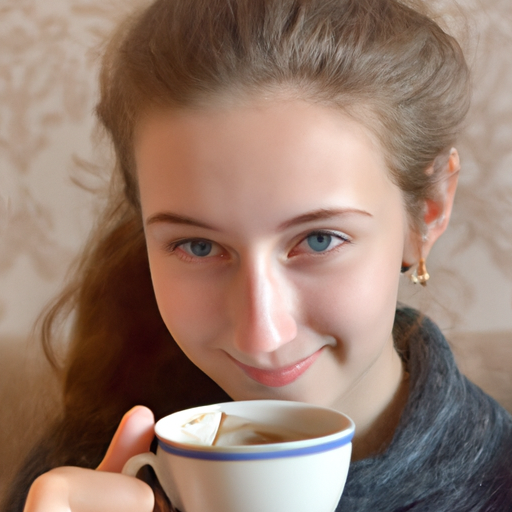

In [7]:
import re
import os
from gradio_client import Client
from IPython.display import Image
# DALL E
client = Client("https://passant-labs-aigc.hf.space/")
result = client.predict("A girl is drinking coffee",api_name="/predict")
img_path = re.sub(r"\.txt$", ".png", result)
print(f"img_path:\n{img_path}")
os.rename(result, img_path)
display(Image(filename=img_path))


In [8]:
from web3 import Web3
from web3.middleware import geth_poa_middleware
import re
import json
import requests
import os
from io import BytesIO

%env PK
%env OWNER
%env PINATA_JWT
%env PINATA_GATEWAY

BSC_RPC_URL="https://rpc.ankr.com/bsc"

OWNER=os.getenv("OWNER")
CONTRACT="0x7CEd67BfB6b25690C3d46a0773679cbeB0e059A6"

PINATA_JWT=os.getenv('PINATA_JWT')
PINATA_GATEWAY=os.getenv("PINATA_GATEWAY")
PINATA_UPLOAD_URL="https://api.pinata.cloud/pinning/pinFileToIPFS"

DEFAULT_HEADERS={"Authorization": f"Bearer {PINATA_JWT}"}

# metadata
img_uri='';img_path="/var/folders/v9/0m7ffhxx1mn6dxrl_nxks6y00000gn/T/gradio/73407bfa8265b5dcb2aac0e2240b1661df8153bc/tmpa1k_32ru.png"
with open(img_path, 'rb') as f:
    result=requests.post(PINATA_UPLOAD_URL, files={"file": f}, headers=DEFAULT_HEADERS)
    cid = result.json()["IpfsHash"]
    img_uri=f"{PINATA_GATEWAY}/ipfs/{cid}"

metadata_path=re.sub(r"\.png$", ".json", img_path)
metadata={
    "image": img_uri, 
    "name": "passant-labs/txt2img", 
    "description": "text to image", 
    "external_url": ""
}
buffered=BytesIO(bytes(json.dumps(metadata), 'utf-8'))
result=requests.post(PINATA_UPLOAD_URL, files={"file": buffered}, headers=DEFAULT_HEADERS)
cid = result.json()["IpfsHash"]
uri=f"{PINATA_GATEWAY}/ipfs/{cid}"

# load abi
abi=[]
with open("abi/collective.json", 'r') as f:
    abi = json.load(f)["abi"]

# mint NFT
w3 = Web3(Web3.HTTPProvider(BSC_RPC_URL))
w3.middleware_onion.inject(geth_poa_middleware, layer=0)
minting = w3.eth.contract(address=CONTRACT, abi=abi)
unsent_tx = minting.functions.mint("", 1, uri).build_transaction({
    "from": OWNER,
    "nonce": w3.eth.get_transaction_count(OWNER),
})
signed_tx = w3.eth.account.sign_transaction(unsent_tx, private_key=os.getenv("PK"))
tx_hash = w3.eth.send_raw_transaction(signed_tx.rawTransaction)

print(f"tx: https://bscscan.com/tx/{tx_hash.hex()}")

tx: https://bscscan.com/tx/0x4b1e4087e4c271e7639350e4e7b2a89a26ae07592cd2a0607228a219da3722ff
